<a href="https://colab.research.google.com/github/av-dutta/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [4]:
#uploading files
file_path = "/content/drive/MyDrive/capstone Alma Better/Data & Resources/NYC Taxi Data.csv"
dataset = pd.read_csv(file_path)
dataset.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
#Checking dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Hence there is no null values in our dataset

In [6]:
#Converting pickup and dropoff into datetime format
dataset['pickup_datetime']= pd.to_datetime(dataset['pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')
dataset['dropoff_datetime']= pd.to_datetime(dataset['dropoff_datetime'],format = '%Y-%m-%d %H:%M:%S')

In [7]:
#Rechecking the datatype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [8]:
#Extracting hour and day of the week using datetime library
dataset.loc[:,'hour'] = dataset['pickup_datetime'].dt.hour
dataset.loc[:,'day_of_week'] = dataset['pickup_datetime'].dt.dayofweek
dataset['day_type'] = 'weekend'
dataset['day_type'][dataset['pickup_datetime'].dt.day_of_week<5] = 'weekday' #Since dates will be numbered from 0 to 6 starting from Monday

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
dataset.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,day_type
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,weekday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,weekend


In [10]:
#Checking unique values of the day_type column
dataset['day_type'].unique()

array(['weekday', 'weekend'], dtype=object)

In [11]:
#Creating bins to divide daytime into different hour slots
hour_bins = [0, 6, 12, 16, 23, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night'] #Since 0 hrs and 24 hrs both represents midnight 
dataset['Session'] = pd.cut(dataset.hour,bins=hour_bins, right=False, labels=labels, ordered=False)

In [12]:
#Creating function to find the distance
from math import sin, cos, sqrt, atan2, radians

def distlatlong(lon1, lat1, lon2, lat2):
  #Converting the latitude and longitude degrees into radian
    lat1 = radians(lat1)  
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
  # The Haversine Formula
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = 6373.0 * c   #Here 6373 is the approximate 
    return distance


In [13]:
#Creating new variable distance
dataset['distance'] = [distlatlong(dataset.pickup_longitude[i],
                              dataset.pickup_latitude[i],
                              dataset.dropoff_longitude[i],
                              dataset.dropoff_latitude[i]) 
                for i in dataset.index]

In [14]:
dataset.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,day_type,Session,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,weekday,Evening,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,weekend,Night,1.806074


#Univariate Analysis

In [15]:
(dataset['passenger_count'].unique())

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

In [16]:
dataset['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

This seems number of passengers as 0,7,8,9 might be anomalies so we can remove the corrosponding rows.



In [17]:
dataset = dataset[(dataset['passenger_count'] >0) & (dataset['passenger_count'] <7)]

In [18]:
dataset.shape

(1458579, 16)

##Trip_duration
Since the records are in seconds we can convert into minutes 

In [19]:
dataset['trip_duration_min'] = dataset['trip_duration']/60.0
dataset['trip_duration_min'].head()

0     7.583333
1    11.050000
2    35.400000
3     7.150000
4     7.250000
Name: trip_duration_min, dtype: float64

In [20]:
pd.cut(dataset['trip_duration_min'],bins=100).value_counts()

(-58.755, 587.73]         1456566
(1175.444, 1763.157]         1930
(587.73, 1175.444]             79
(37025.967, 37613.681]          1
(34087.4, 34675.113]            1
                           ...   
(21157.703, 21745.416]          0
(20569.989, 21157.703]          0
(19982.276, 20569.989]          0
(19394.562, 19982.276]          0
(29385.692, 29973.405]          0
Name: trip_duration_min, Length: 100, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


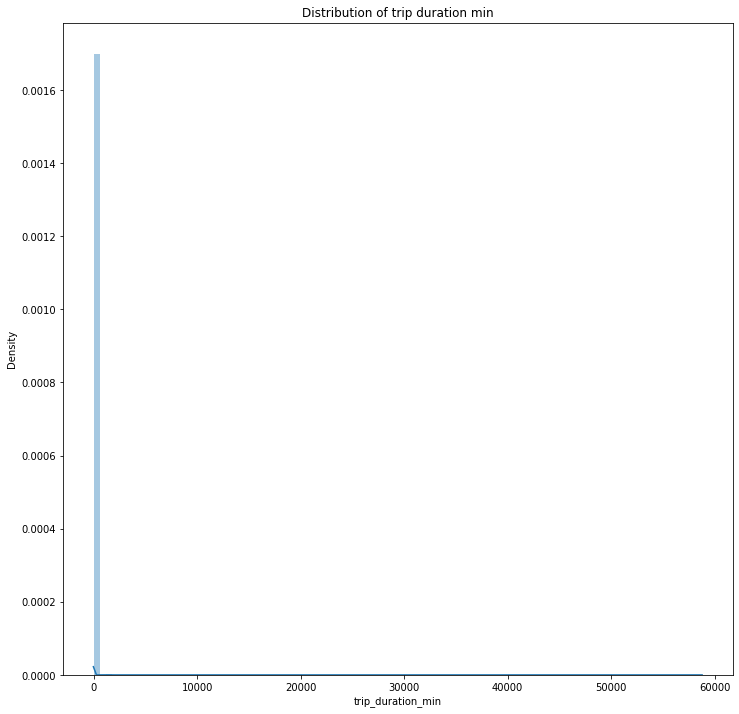

In [21]:
plt.figure(figsize=(12,12))
sns.distplot(dataset['trip_duration_min'], bins=100)
plt.title('Distribution of trip duration min')
plt.show()

On visualising the plot in normal scale, we don't clearly see the less dense trips and also our trip_duration is right skewed, can apply log transformation and check if the distribution is normal.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


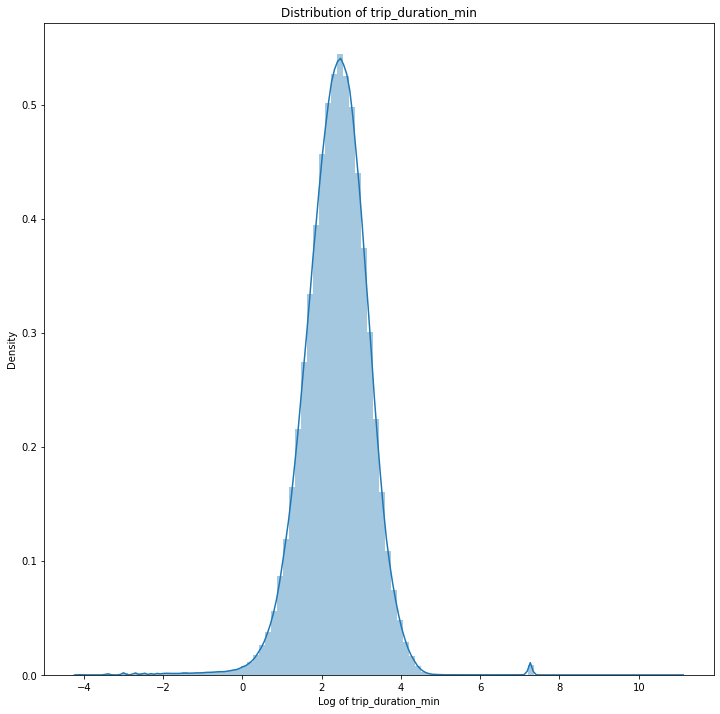

In [22]:
plt.figure(figsize=(12,12))
sns.distplot(np.log(dataset['trip_duration_min']), bins=100)
plt.xlabel('Log of trip_duration_min')
plt.title('Distribution of trip_duration_min')
plt.show()

##Categorical features
Vendors

In [23]:
import seaborn as sns

Text(0.5, 0, 'Vendor Ids')

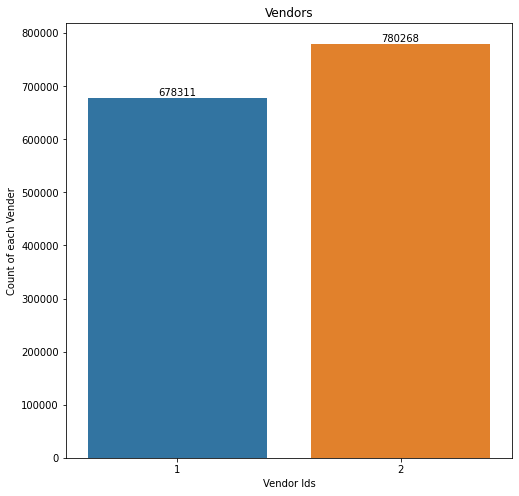

In [24]:
f, ax = plt.subplots(figsize=(8,8))
cplot = sns.countplot(data=dataset, x=dataset['vendor_id'])
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title("Vendors")
cplot.set_ylabel("Count of each Vender")
cplot.set_xlabel("Vendor Ids")

Store and forward flag

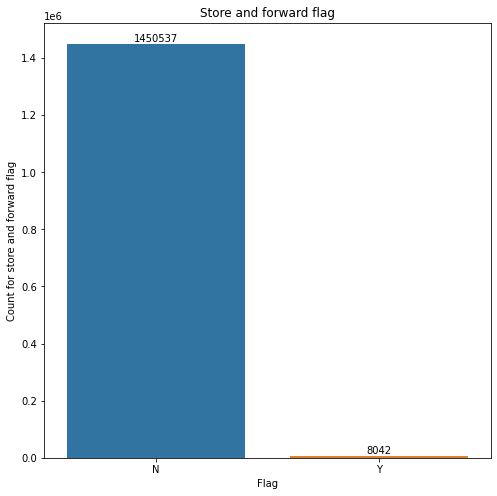

In [25]:
f, ax = plt.subplots(figsize=(8,8))
cplot = sns.countplot(data=dataset, x='store_and_fwd_flag')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title("Store and forward flag")
cplot.set_ylabel("Count for store and forward flag")
cplot.set_xlabel("Flag");

Passenger Count

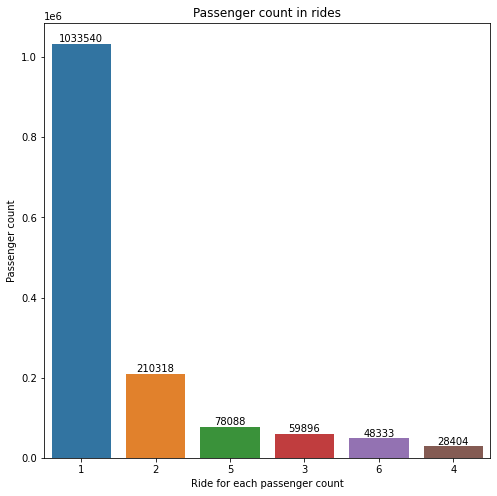

In [26]:
f, ax = plt.subplots(figsize=(8,8))
cplot = sns.countplot(data=dataset, x='passenger_count', order=dataset['passenger_count'].value_counts().index)
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title("Passenger count in rides")
cplot.set_ylabel("Passenger count")
cplot.set_xlabel("Ride for each passenger count");

###Datetime features
Weekends vs Weekdays

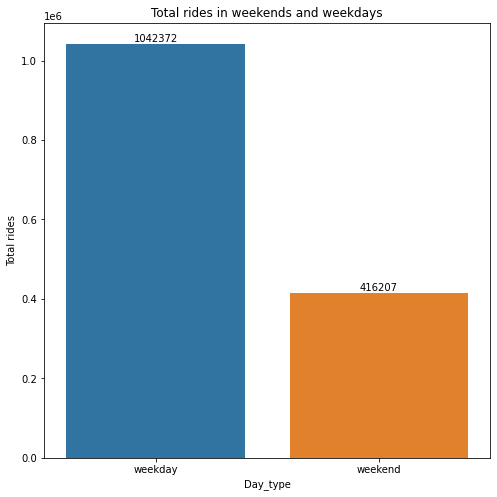

In [27]:
f, ax = plt.subplots(figsize=(8,8))
cplot = sns.countplot(data=dataset, x='day_type')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title("Total rides in weekends and weekdays")
cplot.set_ylabel("Total rides")
cplot.set_xlabel("Day_type");

Day of week

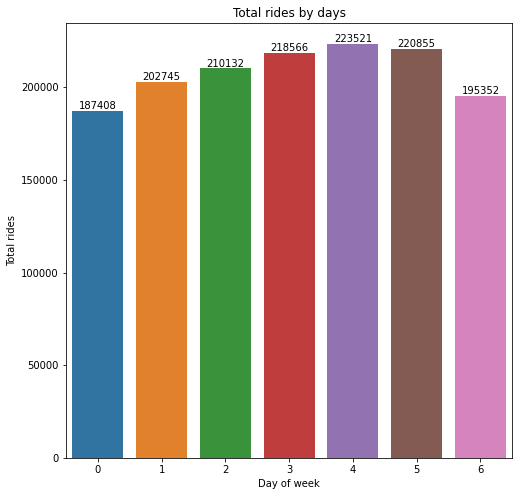

In [28]:
f, ax = plt.subplots(figsize=(8,8))
cplot = sns.countplot(data=dataset, x='day_of_week')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')
cplot.set_title("Total rides by days")
cplot.set_ylabel("Total rides")
cplot.set_xlabel("Day of week");

Hour of the day

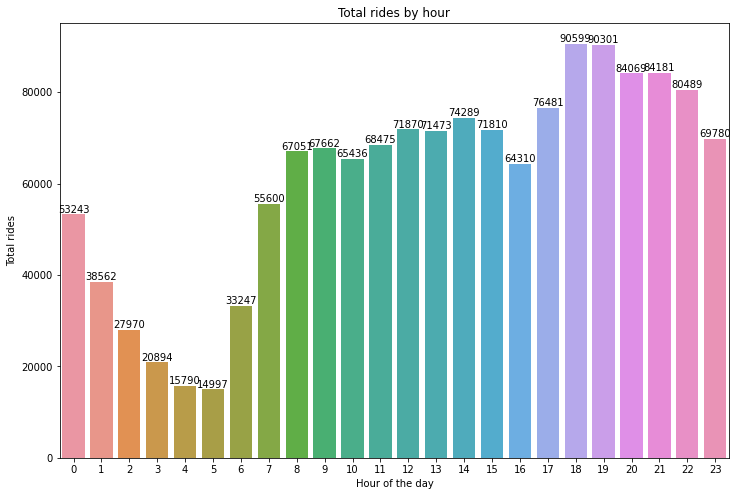

In [29]:
f, ax = plt.subplots(figsize=(12,8))
cplot = sns.countplot(data=dataset, x='hour')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom', fontsize=10)
cplot.set_title("Total rides by hour")
cplot.set_ylabel("Total rides")
cplot.set_xlabel("Hour of the day");

Part of the day

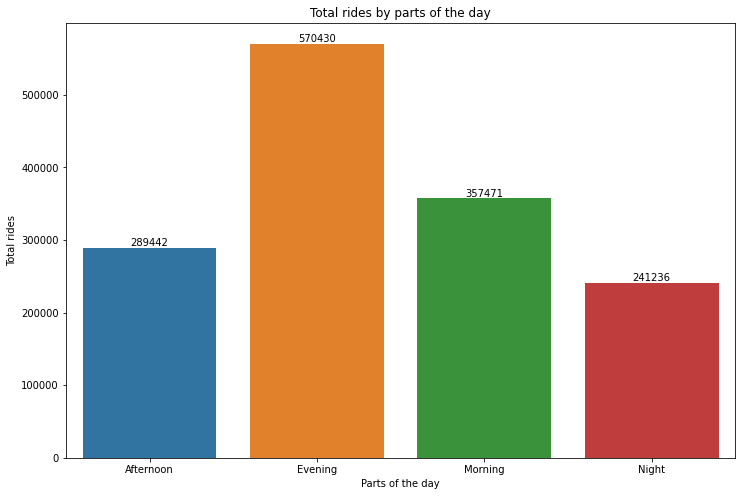

In [30]:
f, ax = plt.subplots(figsize=(12,8))
cplot = sns.countplot(data=dataset, x='Session')
for count in cplot.patches:
    height = count.get_height()
    ax.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom', fontsize=10)
cplot.set_title("Total rides by parts of the day")
cplot.set_ylabel("Total rides")
cplot.set_xlabel("Parts of the day");

Analysing the variables - Multivariate analysis

Trip duration vs Trip distance
Since there are more outliers in Trip duration, visualising it directly doesn't give the whole picture of the relationship

Text(0.5, 1.0, 'log of trip Duration vs trip Distance')

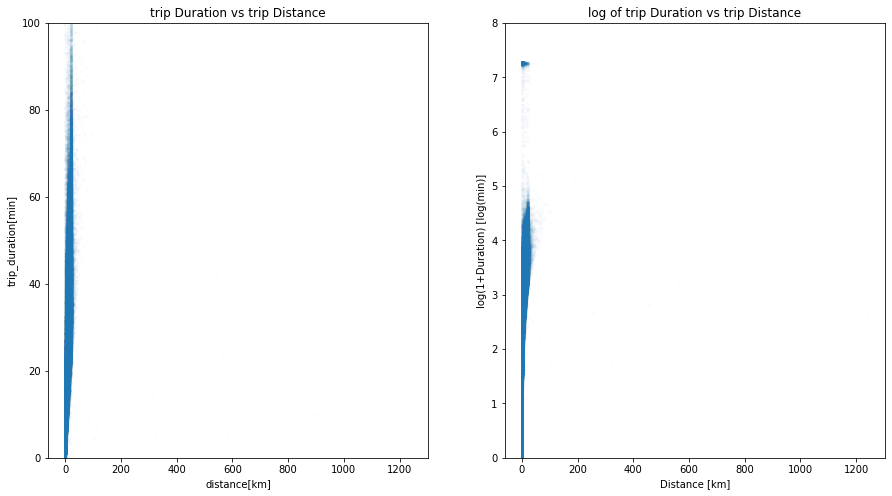

In [31]:
fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
axArray[0].scatter(dataset['distance'], dataset['trip_duration_min'], s=5,alpha=0.01); 
axArray[0].set_xlabel('distance[km]'); 
axArray[0].set_ylabel('trip_duration[min]')
axArray[0].set_ylim(0,100)
axArray[0].set_title('trip Duration vs trip Distance')

axArray[1].scatter(dataset['distance'], np.log(dataset['trip_duration_min']+1),s=5,alpha=0.01); 
axArray[1].set_xlabel('Distance [km]') 
axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_ylim(0,8)
axArray[1].set_title('log of trip Duration vs trip Distance')

From the above plots can infer that as the distance increases, duration of the trip also increases. Since our trip is right skewed distribution, on checking with log transformed values, able to visualise the whole picture of the relationship.

But we have some 0 distance trips with more trip duration. Lets analyse those rides now

In [32]:
dataset[dataset.distance==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,day_type,Session,distance,trip_duration_min
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,18,0,weekday,Evening,0.0,3.783333
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,18,1,weekday,Evening,0.0,18.483333
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,23,0,weekday,Night,0.0,15.783333
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,19,0,weekday,Evening,0.0,9.666667
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,22,2,weekday,Evening,0.0,0.450000


By looking at the ride details, can see that for all the 0 distance ride, dropoff time is more than pickup time. It can be due to 3 reasons.

Dropoff time is not recorded.
Taxi might have stuck in traffic jam and customer would have cancelled the ride.
Manual error.

###Trip duration vs Days based on vendors
Since there are some outliers, can visualise the trip duration column till 95th percentile to give some better idea about the distribution

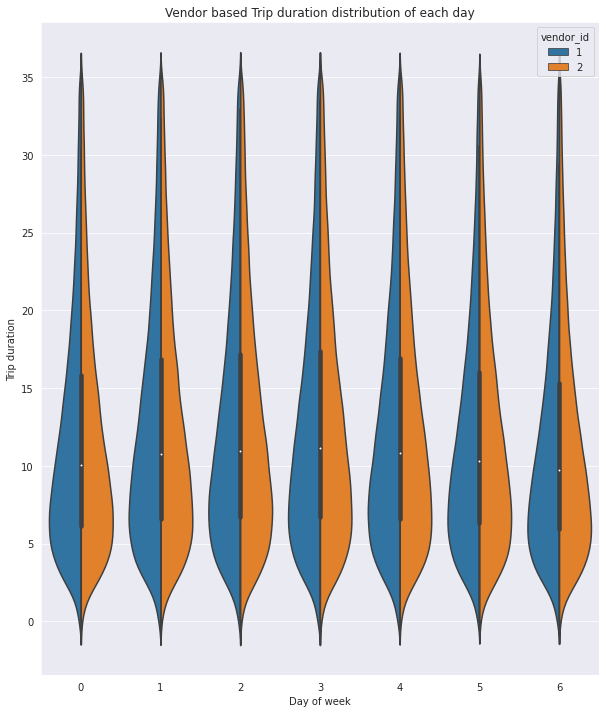

In [33]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,12))
sns.violinplot(data=dataset[dataset['trip_duration_min']<=dataset['trip_duration_min'].quantile(0.95)],x='day_of_week', y='trip_duration_min', hue='vendor_id', split=True)
ax.set_xlabel("Day of week")
ax.set_ylabel("Trip duration")
ax.set_title("Vendor based Trip duration distribution of each day");

From the above figure can infer that,

From the distribution, both the vendors has almost similar duration distribution in each day
Also for each day, duration between most number of rides have 5 to 10 mins duration with each vendor
Can verify the same with the lineplot

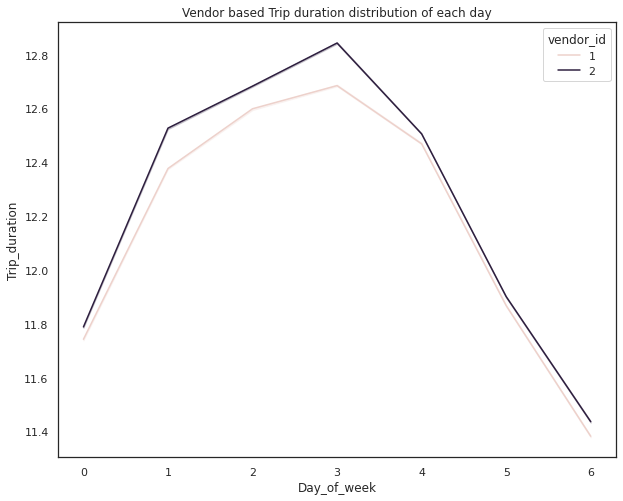

In [34]:
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(10,8))
sns.lineplot(data=dataset[dataset['trip_duration_min']<=dataset['trip_duration_min'].quantile(0.95)],x='day_of_week', y='trip_duration_min', hue='vendor_id',ci=10)
plt.xlabel('Day_of_week')
plt.ylabel('Trip_duration')
plt.title('Vendor based Trip duration distribution of each day');

From the above plot, its clear that both the vendors take almost similar time in all days except wednesday and thrusday

##Vendor based trips in a hour distribution of each day

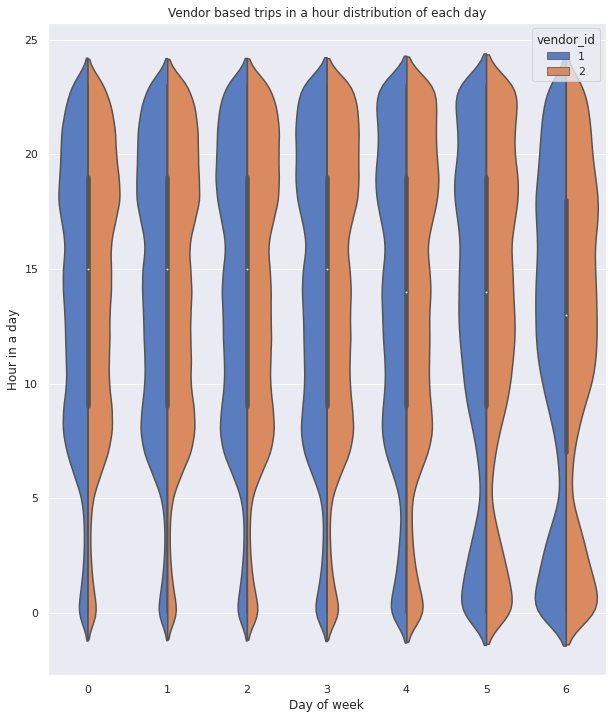

In [35]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,12))
sns.violinplot(data=dataset,x='day_of_week', y='hour', hue='vendor_id', split=True)
ax.set_xlabel("Day of week")
ax.set_ylabel("Hour in a day")
ax.set_title("Vendor based trips in a hour distribution of each day");

###Model Building

In [36]:
#Creating a copy of the dataset
df =dataset.copy()

In [37]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,day_type,Session,distance,trip_duration_min
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,weekday,Evening,1.498991,7.583333
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,weekend,Night,1.806074,11.050000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,weekday,Morning,6.387103,35.400000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,weekday,Evening,1.485965,7.150000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,weekend,Afternoon,1.188962,7.250000


In [38]:
#statistical summary
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458579.0,1.534951,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458579.0,1.664578,1.314181,1.000000,1.000000,1.000000,2.000000,6.000000e+00
pickup_longitude,1458579.0,-73.973487,0.070901,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458579.0,40.750922,0.032880,34.359695,40.737350,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458579.0,-73.973417,0.070643,-121.933304,-73.991325,-73.979752,-73.963020,-6.133553e+01
dropoff_latitude,1458579.0,40.751800,0.035889,32.181141,40.735886,40.754524,40.769810,4.392103e+01
trip_duration,1458579.0,959.463847,5237.072508,1.000000,397.000000,662.000000,1075.000000,3.526282e+06
hour,1458579.0,13.606575,6.399583,0.000000,9.000000,14.000000,19.000000,2.300000e+01
day_of_week,1458579.0,3.050351,1.954031,0.000000,1.000000,3.000000,5.000000,6.000000e+00
distance,1458579.0,3.442042,4.297897,0.000000,1.232299,2.094442,3.876668,1.241298e+03


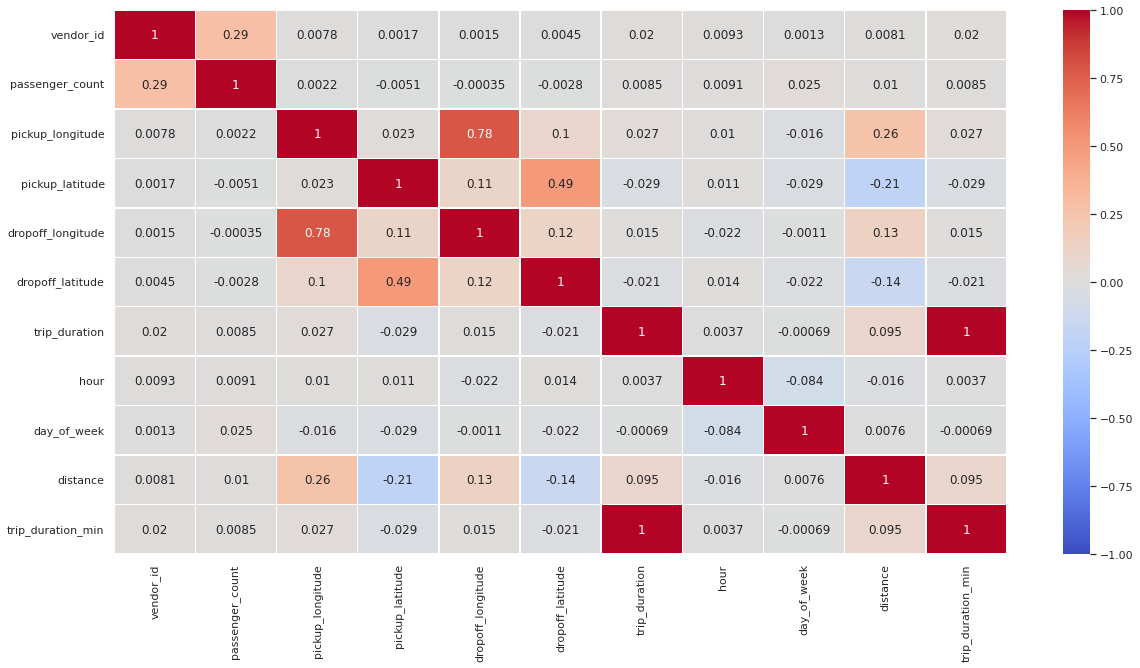

In [39]:
# Getting A Heatmap Co-Relating Various Columns
df_corr=df.corr()
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df_corr, vmin = -1, cmap='coolwarm', linecolor='white',  linewidths=.5, annot=True);

We can drop the varibles which will not contribute for a good model building

In [40]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'hour', 'day_of_week', 'day_type', 'Session',
       'distance', 'trip_duration_min'],
      dtype='object')

In [41]:
df.drop(['id','pickup_datetime','dropoff_datetime','passenger_count','vendor_id','day_type','Session','store_and_fwd_flag','trip_duration_min'],axis=1, inplace=True)

In [42]:
df.head(2)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,day_of_week,distance
0,-73.982155,40.767937,-73.964630,40.765602,455,17,0,1.498991
1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,1.806074


In [43]:
#Splitting data into train and test set
from sklearn.model_selection import train_test_split
y= df['trip_duration']
x= df.drop('trip_duration',axis=1)
X_train, X_test, y_train, y_test = train_test_split( x,y , test_size = 0.2, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(1166863, 7)
(291716, 7)


In [ ]:
#We have to scale our data seperately on train and test dataset
from scipy.stats import zscore
X_train 